# **Biomarker Selection for PE, SLE, HPT, and HPTh**

This notebook performs feature selection to identify significant biomarkers for Preeclampsia (PE), Systemic Lupus Erythematosus (SLE), Hypertension (HPT), and Hypothyroidism (HPTh) using a merged gene expression dataset. Three feature selection methods—Lasso, Random Forest, and SVM-RFE—are applied to rank and select biomarkers. The intersection of selected features is identified, and a t-test is used to verify the statistical significance of the common biomarkers. The results are saved for further analysis.

### **1. Import Libraries**

The following libraries are imported for data manipulation, visualization, statistical testing, and machine learning-based feature selection.

In [28]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

### **2. Load Dataset**

The merged dataset containing gene expression data for PE, SLE, HPT and HPTh is loaded from a CSV file.

In [29]:
# Load the dataset
data = pd.read_csv('clean_data/merged_pe_sle_hpt_hpth_large_data.csv')
data.head()

,PRMT5,RAB32,LPL,PDK4,STAG2,TFRC,PID1,JCHAIN,CBX1,IL21R,...,P2RY14,SCML4,ATP6V1C1,ITSN1,ITGB2,SGMS2,CUTC,HBB,HES1,label
0,599.0,23.0,2225.0,1228.0,1625.0,24789.0,366.0,0.0,449.0,0.0,...,95.0,0.0,1130.0,1075.0,269.0,795.0,83.0,961.0,581.0,1
1,599.0,25.0,1718.0,1085.0,1315.0,11953.0,273.0,0.0,413.0,12.0,...,148.0,0.0,821.0,705.0,242.0,223.0,85.0,1775.0,776.0,1
2,649.0,20.0,3593.0,940.0,1154.0,11993.0,207.0,2.0,397.0,6.0,...,99.0,1.0,541.0,933.0,269.0,423.0,117.0,1204.0,898.0,1
3,565.0,15.0,272.0,1131.0,1448.0,7821.0,333.0,0.0,356.0,4.0,...,104.0,0.0,1099.0,881.0,262.0,589.0,101.0,1557.0,929.0,1
4,780.0,19.0,674.0,1548.0,995.0,6527.0,636.0,0.0,248.0,2.0,...,48.0,0.0,760.0,513.0,333.0,300.0,113.0,1859.0,586.0,1


### **3. Select Features and Target**

The dataset is split into features (X: gene expression values) and the target variable (y: labels indicating disease status).

In [30]:
# Select features and target variable (X, y)
X = data.drop(columns=['label'])
y = data['label']

# Print the shape of the dataset
print(f"Shape of the dataset: {X.shape}, {y.shape}")

Shape of the dataset: (199, 86), (199,)


### **4. Standardize Features**

Features are standardized using StandardScaler to ensure comparability, as many ML algorithms (e.g., SVM) are sensitive to feature scales.

In [31]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [32]:
# Make a dataframe from the scaled features
X = pd.DataFrame(X, columns=data.columns[:-1])

### **5. Visualize Class Distribution**

A count plot visualizes the distribution of classes (e.g., healthy, T2D, CLL) in the dataset.

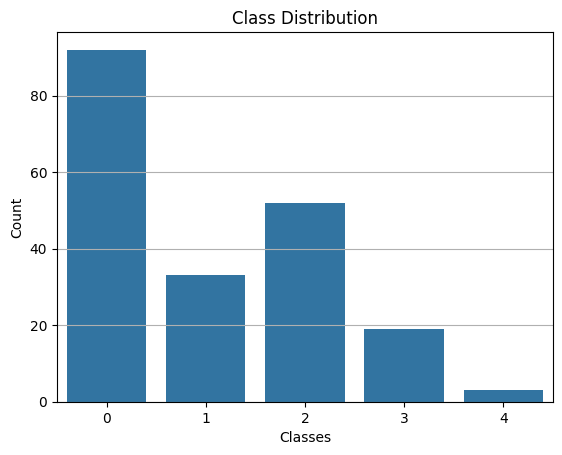

In [33]:
# Visualize the class distribution
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

### **6. Handle Class Imbalance (Commented Out)**

The code for handling class imbalance using SMOTE is present but commented out. It would upsample the minority class and visualize the new class distribution.

Resampled dataset shape: (460, 86), (460,)


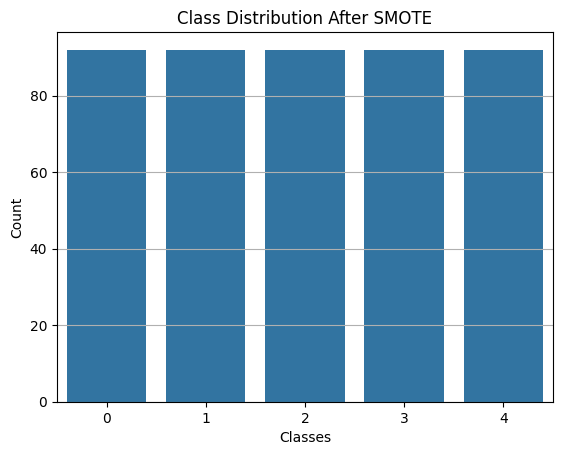

In [34]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42, k_neighbors=2)
X, y = smote.fit_resample(X, y)
# print the shapesbefore and after SMOTE
print(f"Resampled dataset shape: {X.shape}, {y.shape}")
# Visualize the class distribution after SMOTE
sns.countplot(x=y)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

### **7. Lasso Feature Selection**

A Lasso model is trained to select features by shrinking less important feature coefficients to zero. The absolute values of the coefficients are used to rank features.

In [35]:
# Train Lasso model and perform feature selection s
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
importance = np.abs(lasso.coef_)
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)
lasso_feature_importance = feature_importance[feature_importance['Importance'] > 0]
# Print the selected features
print("Number of Biomarkers selected by Lasso:", len(lasso_feature_importance))
print("Selected Biomarkers using Lasso:")
print(lasso_feature_importance)

Number of Biomarkers selected by Lasso: 46
Selected Biomarkers using Lasso:
    Feature  Importance
0   PLEKHA3    0.723396
1     APMAP    0.648611
2      CBX1    0.615961
3     GNG10    0.530056
4      PPT1    0.456089
5       SLA    0.401728
6      ASPH    0.394269
7      YBX3    0.392611
8      TPM1    0.388623
9     ITGB2    0.354012
10   MOSPD2    0.342853
11     PDK4    0.316584
12   NUCKS1    0.289739
13   CLEC7A    0.273327
14    SSBP3    0.200939
15  OSBPL1A    0.192873
16      QKI    0.185878
17    LATS2    0.176229
18      HBB    0.167471
19     CTSB    0.167296
20    BACE2    0.166364
21   SLAMF8    0.158952
22    FGFR1    0.154053
23      LYZ    0.151258
24  HLA-DOA    0.148995
25    SGMS2    0.145019
26      NPL    0.140422
27     PID1    0.132081
28     DIO2    0.130930
29    CEBPA    0.110449
30    ALPK1    0.092919
31    FCHO2    0.082677
32    KLHL6    0.071280
33   CAPZA1    0.070447
34     TFRC    0.070403
35   RNF146    0.065519
36   PFKFB2    0.062837
37    PLIN1 

### **8. Random Forest Feature Selection**

A Random Forest model is trained to select features based on their importance scores, derived from their contribution to classification.

In [36]:
# Train Random Forest model and perform feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importance = rf.feature_importances_
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)
rf_feature_importance = feature_importance[feature_importance['Importance'] > 0]
# Print the selected features
print("Number of Biomarkers selected by Random Forest:", len(rf_feature_importance))
print("Selected Biomarkers using Random Forest:")
print(rf_feature_importance)

Number of Biomarkers selected by Random Forest: 86
Selected Biomarkers using Random Forest:
    Feature  Importance
0     ITSN1    0.049419
1   SLC16A7    0.041940
2     SGMS2    0.039656
3       LPL    0.033849
4      ASPH    0.033171
..      ...         ...
81    ITGB2    0.001451
82   RPL37A    0.001367
83    LATS2    0.001213
84     YBX3    0.001195
85      SLA    0.000990

[86 rows x 2 columns]


### **9. SVM-RFE Feature Selection**

SVM-RFE is used to select the top 10 features by iteratively eliminating the least important features based on SVM weights.

In [37]:
# Train SVM-RFE model and perform feature selection
svm = SVC(kernel='linear', random_state=42)
rfe = RFE(estimator=svm, n_features_to_select=10)
rfe.fit(X, y)
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rfe.ranking_})
# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)
svmrfe_feature_importance = feature_importance[feature_importance['Importance'] > 0.0]
# Print the selected features
print("Number of Biomarkers selected by SVM-RFE:", len(svmrfe_feature_importance))
print("Selected Biomarkers using SVM-RFE:")
print(svmrfe_feature_importance)

Number of Biomarkers selected by SVM-RFE: 86
Selected Biomarkers using SVM-RFE:
   Feature  Importance
0    SCML4          77
1    TPPP3          76
2      CR1          75
3    CIITA          74
4      LCK          73
..     ...         ...
81   CEBPA           1
82     QKI           1
83   LATS2           1
84   YWHAG           1
85   ITSN1           1

[86 rows x 2 columns]


### **10. Intersection of Selected Features**

The common biomarkers selected by all three methods (Lasso, Random Forest, and SVM-RFE) are identified.

In [38]:
# Intersection of selected features from all three methods
lasso_features = set(lasso_feature_importance['Feature'])
rf_features = set(rf_feature_importance['Feature'])
svmrfe_features = set(svmrfe_feature_importance['Feature'])
intersection_features = lasso_features.intersection(rf_features).intersection(svmrfe_features)
# Print the intersection of selected features
print("Number of Biomarkers in intersection:", len(list(intersection_features)))
print("Intersection of Selected Biomarkers:")
print(intersection_features)

Number of Biomarkers in intersection: 46
Intersection of Selected Biomarkers:
{'SLA', 'MOSPD2', 'SLAMF8', 'SEL1L3', 'CAPZA1', 'IFIT3', 'TPM1', 'CBX1', 'PLIN1', 'SSBP3', 'CTSB', 'PPT1', 'ALPK1', 'SGMS2', 'GNG10', 'YBX3', 'QKI', 'LATS2', 'KCNIP2', 'AKAP12', 'FGFR1', 'OSBPL1A', 'HES1', 'ASPH', 'PLEKHA3', 'NPL', 'LYZ', 'CLEC7A', 'BACE2', 'ITGB2', 'APMAP', 'HLA-DOA', 'DIO2', 'LPL', 'PDK4', 'KLHL6', 'TFRC', 'SDC2', 'RNF146', 'PID1', 'PFKFB2', 'IL2RB', 'FCHO2', 'NUCKS1', 'HBB', 'CEBPA'}


### **11. Compile Selected Features with Scores**

A DataFrame is created to compile the importance scores from all three methods for the common biomarkers.



In [39]:
# Create a new DataFrame with the selected features with scores from all three methods
# Create a list to store rows
rows = []
for feature in intersection_features:
    lasso_score = lasso_feature_importance[lasso_feature_importance['Feature'] == feature]['Importance'].values[0]
    rf_score = rf_feature_importance[rf_feature_importance['Feature'] == feature]['Importance'].values[0]
    svmrfe_score = svmrfe_feature_importance[svmrfe_feature_importance['Feature'] == feature]['Importance'].values[0]
    rows.append({
        'Feature': feature,
        'Lasso': lasso_score,
        'Random Forest': rf_score,
        'SVM-RFE': svmrfe_score
    })

selected_features = pd.DataFrame(rows)
# Print the selected features with scores
print("Selected Biomarkers with Scores:")
print(selected_features)
# Save to CSV
selected_features.to_csv('results/pe_sle_hpt_hpth_large_multimode_selected_features.csv', index=False)

Selected Biomarkers with Scores:
    Feature     Lasso  Random Forest  SVM-RFE
0       SLA  0.401728       0.000990       45
1    MOSPD2  0.342853       0.018309        8
2    SLAMF8  0.158952       0.001939       23
3    SEL1L3  0.014310       0.020410       61
4    CAPZA1  0.070447       0.013191       69
5     IFIT3  0.004174       0.012310       32
6      TPM1  0.388623       0.026471       29
7      CBX1  0.615961       0.013143       13
8     PLIN1  0.043352       0.005531       41
9     SSBP3  0.200939       0.002338       55
10     CTSB  0.167296       0.007623       46
11     PPT1  0.456089       0.009263       27
12    ALPK1  0.092919       0.024490       22
13    SGMS2  0.145019       0.039656       26
14    GNG10  0.530056       0.004604        3
15     YBX3  0.392611       0.001195       11
16      QKI  0.185878       0.004111        1
17    LATS2  0.176229       0.001213        1
18   KCNIP2  0.040912       0.019690       31
19   AKAP12  0.021141       0.025245       48
2

### **12. Verify Common Biomarkers with T-test**

A t-test is performed to verify the statistical significance of the common biomarkers by comparing their expression levels between healthy (label 0) and T2D (label 1) groups.

In [40]:
# Verify the common biomarkers with t-test
# Load the dataset again
data = pd.read_csv('clean_data/merged_pe_sle_hpt_hpth_large_data.csv')
# Select features and target variable (X, y)
X = data.drop(columns=['label'])
y = data['label']
# Select the common biomarkers
common_biomarkers = list(intersection_features)
# Create a new DataFrame with the common biomarkers
common_biomarkers_df = data[common_biomarkers]
# Add the target variable
common_biomarkers_df['label'] = y
# Perform t-test for each common biomarker
t_test_results = []
for feature in common_biomarkers:
    group1 = common_biomarkers_df[common_biomarkers_df['label'] == 0][feature]
    group2 = common_biomarkers_df[common_biomarkers_df['label'] == 1][feature]
    t_stat, p_value = ttest_ind(group1, group2)
    t_test_results.append({
        'Feature': feature,
        't-statistic': t_stat,
        'p-value': p_value
    })
# Create a DataFrame for t-test results
t_test_results_df = pd.DataFrame(t_test_results)
# Print the t-test results
print("T-test Results:")
print(t_test_results_df.sort_values(by='p-value', ascending=True).reset_index(drop=True))
# Save t-test results to CSV
t_test_results_df.to_csv('results/pe_sle_hpt_hpth_large_multimode_t_test_results.csv', index=False)


T-test Results:
    Feature  t-statistic       p-value
0     BACE2    -8.076135  5.206802e-13
1     FCHO2    -7.832893  1.904582e-12
2    RNF146    -7.473358  1.265963e-11
3      CTSB    -6.720348  6.015954e-10
4    AKAP12    -6.237666  6.522740e-09
5      ASPH    -6.212381  7.373484e-09
6      SDC2    -5.219392  7.393959e-07
7    SLAMF8    -4.772399  5.065557e-06
8     FGFR1    -4.720932  6.279625e-06
9      PID1    -4.214822  4.796673e-05
10     CBX1    -4.001210  1.080967e-04
11    SSBP3    -3.894527  1.604757e-04
12  PLEKHA3    -3.774588  2.480532e-04
13    IL2RB    -3.760795  2.606369e-04
14  OSBPL1A    -3.586885  4.811943e-04
15   SEL1L3    -3.538766  5.681301e-04
16    GNG10    -3.363259  1.027330e-03
17      QKI    -3.333262  1.134374e-03
18    LATS2    -2.520173  1.301026e-02
19   CAPZA1    -2.354491  2.013193e-02
20     DIO2    -2.272992  2.476177e-02
21   NUCKS1    -2.232103  2.741837e-02
22     HES1    -2.007132  4.692784e-02
23    ITGB2     1.930439  5.585413e-02
24      L

/tmp/ipykernel_26239/540075676.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_biomarkers_df['label'] = y


In [41]:
# print the genes with p-value < 0.05
significant_genes = t_test_results_df[t_test_results_df['p-value'] < 0.05].sort_values(by='p-value', ascending=True).reset_index(drop=True)
print("Significant Genes:")
print(significant_genes)
# Save significant genes to CSV
significant_genes.to_csv('results/pe_sle_hpt_hpth_large_multimode_significant_genes.csv', index=False)

Significant Genes:
    Feature  t-statistic       p-value
0     BACE2    -8.076135  5.206802e-13
1     FCHO2    -7.832893  1.904582e-12
2    RNF146    -7.473358  1.265963e-11
3      CTSB    -6.720348  6.015954e-10
4    AKAP12    -6.237666  6.522740e-09
5      ASPH    -6.212381  7.373484e-09
6      SDC2    -5.219392  7.393959e-07
7    SLAMF8    -4.772399  5.065557e-06
8     FGFR1    -4.720932  6.279625e-06
9      PID1    -4.214822  4.796673e-05
10     CBX1    -4.001210  1.080967e-04
11    SSBP3    -3.894527  1.604757e-04
12  PLEKHA3    -3.774588  2.480532e-04
13    IL2RB    -3.760795  2.606369e-04
14  OSBPL1A    -3.586885  4.811943e-04
15   SEL1L3    -3.538766  5.681301e-04
16    GNG10    -3.363259  1.027330e-03
17      QKI    -3.333262  1.134374e-03
18    LATS2    -2.520173  1.301026e-02
19   CAPZA1    -2.354491  2.013193e-02
20     DIO2    -2.272992  2.476177e-02
21   NUCKS1    -2.232103  2.741837e-02
22     HES1    -2.007132  4.692784e-02


In [42]:
common_genes_biological_process = pd.read_excel('clean_data/common_gene_pe_sle_hpt_hpth.xlsx')
common_genes_biological_process

,Gene
0,AKT1
1,ACTZ
2,CD44
3,TFRC
4,PTPRC
5,TNF


In [43]:
# Intersection of selected features and common genes
intersection = set(selected_features['Feature']).intersection(set(common_genes_biological_process['Gene']))
print("Intersection of selected features and common genes:")
print(intersection)

Intersection of selected features and common genes:
{'TFRC'}
